# Lec 25: Big Data

**by Josh Hug (Fall 2018)**

In [1]:
# Lec 24: Clustering

**by Josh Hug (Fall 2019)**import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

# Installing PySpark Locally

Comment out the following lines to install Spark locally in the same folder as this notebook:

In [4]:
# !curl -O http://mirrors.ocf.berkeley.edu/apache/spark/spark-2.4.0/spark-2.4.0-bin-hadoop2.7.tgz 
# !tar -xvf spark-2.4.0-bin-hadoop2.7.tgz 

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  217M  100  217M    0     0  2426k      0  0:01:31  0:01:31 --:--:-- 2877k10 1569k 0:01:18  0:01:02  0:00:16 3528k
tar: spark-2.2.0-bin-hadoop2.7.tgz: Cannot open: No such file or directory
tar: Error is not recoverable: exiting now


The following Python Library will configure your python environment

In [6]:
#!pip install findspark

You are using pip version 9.0.1, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


If you would like to try using Spark on a cluster for free without any setup checkout [Databricks Community Edition](https://databricks.com/try-databricks)

# Launching PySpark

Setup the PySpark environment.

In [2]:
import os
import findspark
os.environ["PYSPARK_PYTHON"] = "python3"
findspark.init("spark-2.4.0-bin-hadoop2.7",)

Import a few common components of Spark SQL

In [3]:
from pyspark.sql import SparkSession, Column, Row, functions as F 

Initialize the SparkSQL session which contains a basic Spark Context.  This may take a few moments to launch the cluster of (typically 4 to 8 python jobs in the background).  Note in a real Spark deployment you would simply change the `.master("local[*]")` to instead point to the YARN resource manager.  To learn more about deploying Spark on a cluster of machines read [this tutorial](https://spark.apache.org/docs/latest/cluster-overview.html).

Note: You must have Java installed on your computer for this to work!

In [5]:
spark = (
    SparkSession.builder
        .master("local[*]")
        .appName("LectureExample")
        .getOrCreate()
)
sc = spark.sparkContext

# Running Basic Spark Commands

## Word Count Example

As a quick example of what Spark can do, the following code will compute the word counts of Moby Dick in a parallelized fashion. That means that if your computer has multiple processors, they are all put to use computing the word counts.

Below the layer of abstraction that we can see, it is running map reduce.

In [24]:
moby_dick = sc.textFile("./mobydick.txt")

words = moby_dick.flatMap(lambda line: line.split(" "))
counts = words.map(lambda word: (word, 1)) \
              .reduceByKey(lambda a, b: a + b)

counts.toDF().toPandas()

,_1,_2
0,Loomings,1
1,,5882
2,Call,2
3,years,59
4,never,189
5,mind,54
6,long,253
7,precisely-,2
8,no,442
9,money,6


Note: Spark supports the Hadoop File System. If this code were being run on a distributed filesystem, we'd use something like `moby_dick = sc.textFile("hdfs:///books/mobydick.txt")`.

We haven't explained anything above about how the example works! Let's try a couple of additional examples and explain what's going on along the way.

## RDDs and Dataframes

Spark exposes two interfaces to data:

1. An [RDD](http://spark.apache.org/docs/2.1.0/api/python/pyspark.html#pyspark.RDD) interface which represents a collection of rows which can be any python object.
1. A [dataframe](http://spark.apache.org/docs/2.1.0/api/python/pyspark.sql.html) interface which is similar to Pandas (but with less functionality) and built on top of the RDD interface

Today Spark users are encouraged to try to use the dataframe interface which provides additional system performance optimizations. However, in the homework and in this notebook we will use a bit of both to get some exposure the the low-level side of distributed data processing.




### The following creates an RDD with 32 numbers 

The `sc` variable contains the SparkContext initialized above and it is used to created new RDDs.  In this example we use python to create 32 numbers locally and then `sc.parallelize` to distribute those 32 numbers to our cluster of machines.  Each machine gets a subset of the numbers.  If we had more than 32 machines then some will not be given a number.

In [26]:
numbers = sc.parallelize(range(32))

### Basic operations on RDDs

There are a wide range of basic operations on RDDs.  Each of these operations runs across all the workers and results in either a value or another RDD.

In [27]:
numbers.sum()

496

In [28]:
numbers.count()

32

In [29]:
print(numbers.take(2))

[0, 1]


In [30]:
print(numbers.collect())

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]


In [31]:
numbers.filter(lambda x: x % 2 == 0)

PythonRDD[135] at RDD at PythonRDD.scala:53

In [32]:
numbers.filter(lambda x: x % 2 == 0).count()

16

In [33]:
( # What does this do?
    numbers
     .map(lambda x: x + 1)
     .filter(lambda x: x % 2 == 0)
     .map(lambda x: str(x) + " is even.")
     .collect()
)

['2 is even.',
 '4 is even.',
 '6 is even.',
 '8 is even.',
 '10 is even.',
 '12 is even.',
 '14 is even.',
 '16 is even.',
 '18 is even.',
 '20 is even.',
 '22 is even.',
 '24 is even.',
 '26 is even.',
 '28 is even.',
 '30 is even.',
 '32 is even.']

The above operations resulted in jobs being executed on a local Spark workers (separate python instances).  We can learn more about the Spark configuration here.  Click on the SparkUI link to view your local cluster.

In [34]:
spark

Are these really running on remote processes:

In [16]:
os.getpid()

238

In [35]:
import os
numbers.map(lambda x: os.getpid()).distinct().collect()

[7048, 7033, 7042, 7019, 7036, 7045, 7022, 7039]

## Parallelism and Spark

Let's use Spark to parallelize a simulation.

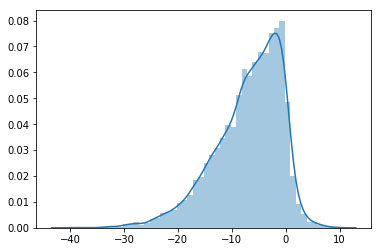

In [42]:
import numpy as np
import seaborn as sns
np.random.seed(42)

weird_data = np.random.randn(10000)**2 - 10 *np.abs( np.random.randn(10000) )
sns.distplot(weird_data)

In [43]:
def resample(data, seed):
    import numpy as np
    np.random.seed(seed)
    return data[np.random.randint(0, len(data),len(data))]

def boot_strap_mean(data, seed):
    return resample(data, seed).mean()

In [44]:
boot_strap_mean(weird_data, 43)

-6.9695617554374332

We can set up a bunch of random seeds and compute bootstrap means for each.

In [56]:
seeds = np.arange(10000) + 42

In [57]:
samples_local = np.array([
    boot_strap_mean(weird_data, seed)
for seed in seeds])

And the average sample mean is...

In [67]:
np.mean(samples_local)

-6.9557852140766245

Or we can plot the distribution of our boostrap means for more information:

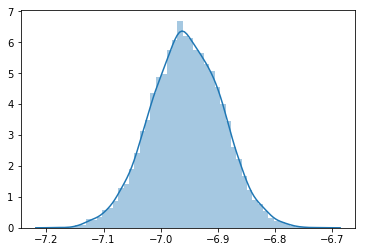

In [58]:
sns.distplot(samples_local)

Let's see how long computation of the sample means above took using the iPython `%%timeit` command, which will rerun the code 8 times and compute the average time needed.

In [59]:
%%timeit
samples_local = np.array([
    boot_strap_mean(weird_data, seed)
for seed in seeds])

1.88 s ± 149 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Once Again, with Spark

Let's see if we can do better by using Spark.

In [4]:
samples = (
    sc.parallelize(seeds)
        .map(lambda seed: boot_strap_mean(weird_data, seed))
)

NameError: name 'sc' is not defined

In [ ]:
samples.count()

The average of the sample means is the same as before.

In [62]:
samples.mean()

-6.9557852140766245

In [63]:
samples.mean()

-6.9557852140766245

If we look at our samples, we should see the exact same distribution as in our non-parallel computation above.

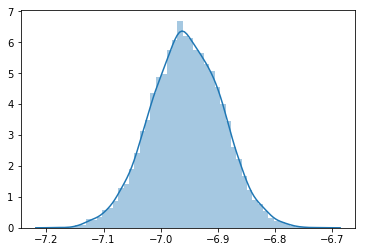

In [64]:
sns.distplot(samples.collect())

Since everything looks good, let's see how long it takes Spark. We see a significant improvement!

In [65]:
%%timeit

samples.mean()

643 ms ± 54.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Caching in Spark

One of the key innovations in Spark is the ability to cache computation. 

In [68]:
samples.persist()

PythonRDD[246] at collect at <ipython-input-64-271f851ee8a8>:1

This time when we run it the result will get saved

In [69]:
samples.mean()

-6.9557852140766245

If we run it again things will be much faster

In [70]:
samples.mean()

-6.9557852140766245

Timing after warming the cache, and we see things are much much faster.

In [72]:
%%timeit 
samples.mean()

68.5 ms ± 4.28 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


# Parsing Text

Here we will work through the standard process of preparing a text dataset.  Note that while we will be loading from the local filesystem here. In a distributed computing environment the arguments to the text file command would be very similar (see below).

Uncomment the following lines to download some text data to process.

In [34]:
# !curl -O https://archive.ics.uci.edu/ml/machine-learning-databases/00228/smsspamcollection.zip
# !unzip smsspamcollection.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  198k  100  198k    0     0   434k      0 --:--:-- --:--:-- --:--:--  435k
Archive:  smsspamcollection.zip
  inflating: SMSSpamCollection       
  inflating: readme                  


The following line will load the text file into an RDD.  If this file were running in a distributed filesystem the path would have been:
```python
raw_lines = sc.textFile("hdfs://silly_data/SMSSPamCollection")
```

In [6]:
raw_lines = sc.textFile("./SMSSpamCollection")

We can get a look at a few lines:


In [6]:
raw_lines.take(3)

['ham\tGo until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...',
 'ham\tOk lar... Joking wif u oni...',
 "spam\tFree entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's"]

In the following RDD code we can transform the data file into records:

In [7]:
records = (
    raw_lines
        .map(lambda x: x.lower()) # Make it lower case
        .map(lambda x: x.split("\t")) # Split records
        .map(lambda x: Row(label=x[0], text=x[1])) # Make Row objects (from SparkSQL)
)

In [8]:
records.take(3)

[Row(label='ham', text='go until jurong point, crazy.. available only in bugis n great world la e buffet... cine there got amore wat...'),
 Row(label='ham', text='ok lar... joking wif u oni...'),
 Row(label='spam', text="free entry in 2 a wkly comp to win fa cup final tkts 21st may 2005. text fa to 87121 to receive entry question(std txt rate)t&c's apply 08452810075over18's")]

How many Spam

In [9]:
records.filter(lambda x: x['label'] == 'spam').count()

747

How many Ham

In [10]:
records.filter(lambda x: x['label'] == 'ham').count()

4827

## Computing Word Counts

If we wanted to determine if a post is spam we might first check to see if it has words that occur more often in spam messages. This is similar to the unexplained word count example above. Let's first see what `flatMap` does.

In [11]:
sc.range(1,5).collect()

[1, 2, 3, 4]

In [12]:
sc.range(1,5).map(lambda x: [i for i in range(x) ]).collect()

[[0], [0, 1], [0, 1, 2], [0, 1, 2, 3]]

In [13]:
sc.range(1,5).flatMap(lambda x: [i for i in range(x) ]).collect()

[0, 0, 1, 0, 1, 2, 0, 1, 2, 3]

Let's count how often each word occurs:

In [11]:
word_counts = (
    records
        .map(lambda x: x['text'])     # extract the text
        .flatMap(lambda x: x.split()) # split on whitespace and
                                      # convert each word into a separate record.
        .filter(lambda x: len(x) > 2) # keep words that have 3 or more letters
        .map(lambda x: (x, 1))           # Count each word 
        .reduceByKey(lambda a, b: a + b) # Sum the counts
)

In [12]:
word_counts.map(lambda x: (x[1], x[0])).top(10)

[(1921, 'you'),
 (1328, 'the'),
 (968, 'and'),
 (703, 'for'),
 (677, 'your'),
 (571, 'have'),
 (559, 'call'),
 (486, 'are'),
 (470, 'that'),
 (422, 'but')]

We can return the result as a Spark dataframe using `toDF()`. Spark dataframes are a relatively basic, less powerful version of the pandas dataframe.

In [32]:
word_counts.toDF()

DataFrame[_1: string, _2: bigint]

Spark dataframes can also be transformed into pandas dataframes using toPandas.

In [14]:
word_counts.toDF().toPandas().head(20)

,_1,_2
0,until,27
1,jurong,1
2,crazy..,1
3,only,184
4,world,24
5,buffet...,1
6,there,135
7,got,235
8,amore,1
9,wat...,12


## Word Counts by Label

In [17]:
word_counts_by_label = (
    records
        .flatMap(lambda x: ((x['label'], w) for w in x['text'].split()))    
        .filter(lambda x: len(x[1]) > 2) # keep words that have 3 or more letters
        .map(lambda x:  # Count each word 
             (x[1], np.array([1.0, 0.0]) if x[0] == 'spam' else np.array([0.0, 1.0])  ))          
        .reduceByKey(lambda a, b: a + b) # Sum the counts
)

In [17]:
word_counts_by_label.take(3)

[('until', array([  5.,  22.])),
 ('jurong', array([ 0.,  1.])),
 ('crazy..', array([ 0.,  1.]))]

Let's compute the ratio of occurrences of each word in spam vs. ham.

In [18]:
spam_ratio = (
    word_counts_by_label.
        map(lambda x: (x[0], (x[1][0] + 1.0) / (x[1][1] + 1.0)))
)    

In [20]:
spam_ratio.take(4)

[('until', 0.2608695652173913),
 ('jurong', 0.5),
 ('crazy..', 0.5),
 ('only', 0.56302521008403361)]

Taking the top spam ratio words we get:

In [21]:
spam_ratio.map(lambda x: (x[1], x[0])).top(10)

[(107.0, 'claim'),
 (65.0, 'won'),
 (59.0, 'prize'),
 (43.0, 'urgent!'),
 (41.0, 'tone'),
 (39.0, 'awarded'),
 (34.0, '£1000'),
 (31.0, '150ppm'),
 (30.0, 'guaranteed'),
 (27.0, 'entry')]

## Where and Select

The SparkSQL and Spark Dataframe interfaces are generally preferred for basic data manipulation.

These functions are heavily optimized and can often result in easier to read code.

In [24]:
sparkdf = records.toDF()

We can apply filter operations using `.where(...)`.  Note here that the `df['lable']` refers to the label column of the dataframe. 

In [25]:
sparkdf.where(sparkdf['label'] == "spam")

DataFrame[label: string, text: string]

We can use the `select` command to select columns and even apply computation.  The `F.length` describes the `length` function SparkSQL functions `F` and the `.alias(...)` command is like `as` in SQL (renames the column).

In [26]:
(
    sparkdf
        .where(sparkdf['label'] == "spam")
        .select(sparkdf['label'], F.length(sparkdf['text']).alias("textlen"))

).take(5)

[Row(label='spam', textlen=155),
 Row(label='spam', textlen=147),
 Row(label='spam', textlen=157),
 Row(label='spam', textlen=154),
 Row(label='spam', textlen=136)]

## GroupBy Operations

Are Spam shorter on average?

In [27]:
(
    sparkdf.groupBy(sparkdf['label']).agg(
        F.avg(F.length(sparkdf['text'])).alias("avg_len"),
        F.stddev(F.length(sparkdf['text'])).alias("stdev_len")
    )
).toPandas()

,label,avg_len,stdev_len
0,ham,71.471929,58.326643
1,spam,138.676037,28.871250


## It's All Just SQL

You can also register dataframes as tables that can be addressed in SQL strings:

In [28]:
sparkdf.registerTempTable("ham_spam_data")

In [29]:
spark.sql("""
    SELECT label, avg(length(text))
    FROM ham_spam_data
    GROUP BY label
""").toPandas()

,label,avg(length(text))
0,ham,71.471929
1,spam,138.676037
